__Homework 6__

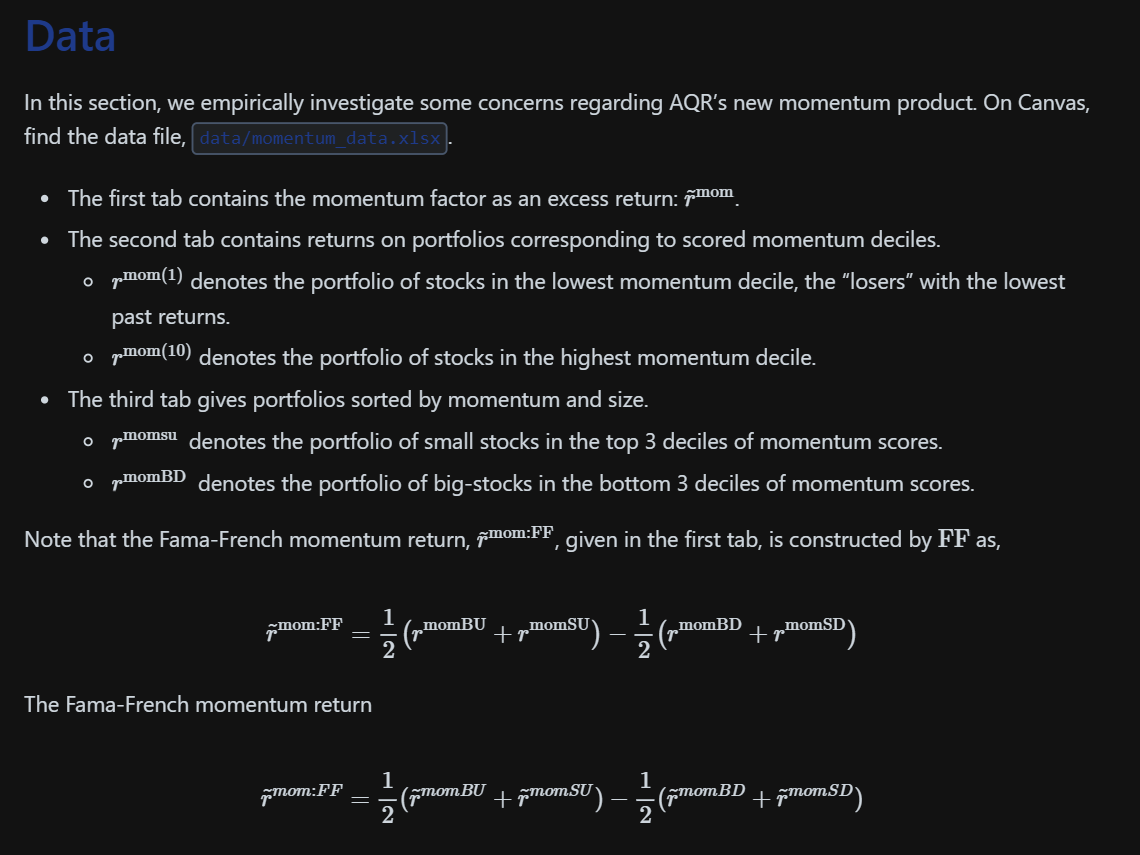

__2.1__

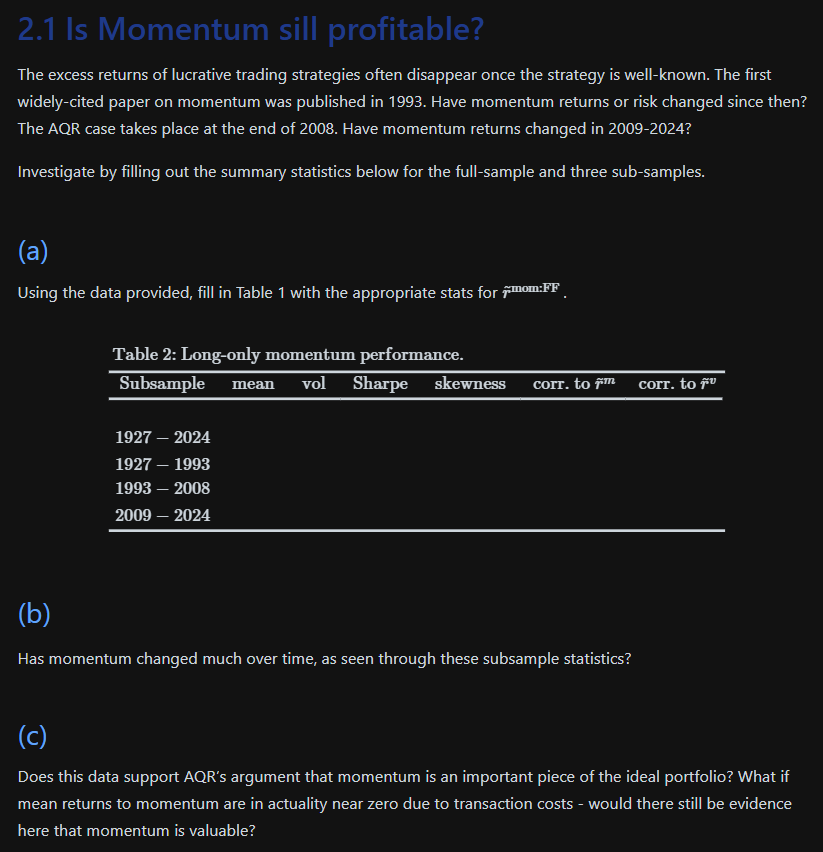

In [13]:
import pandas as pd
import numpy as np
import os

FILE_PATH = 'momentum_data.xlsx'

# Sheet names for different factors
MOMENTUM_SHEET_NAME = 'momentum (excess returns)'  
FACTORS_SHEET_NAME = 'factors (excess returns)'   

# Column names in the momentum sheet
MOMENTUM_COL = 'UMD'
DATE_COL_MOMENTUM = 'Date'

# Column names in the factors sheet
MARKET_COL = 'MKT'
VALUE_COL = 'HML'
DATE_COL_FACTORS = 'Date'

def load_and_prepare_data(file_path):
    """
    Loads and prepares the factor data from both sheets of the Excel file.
    
    Args:
        file_path (str): Path to the Excel file.

    Returns:
        pd.DataFrame: A DataFrame with a DatetimeIndex and all factor returns,
                      or None if the file/sheets are not found.
    """
    
    if not os.path.exists(file_path):
        print(f"Error: Data file not found at '{file_path}'")
        print("Please download the 'momentum_data.xlsx' file and place it in the correct directory.")
        return None

    try:
        # Load both sheets
        mom_df = pd.read_excel(file_path, sheet_name=MOMENTUM_SHEET_NAME)
        factors_df = pd.read_excel(file_path, sheet_name=FACTORS_SHEET_NAME)
        
        # --- Data Cleaning and Preparation for Both Sheets ---
        # 1. Check for date columns
        if DATE_COL_MOMENTUM not in mom_df.columns:
            print(f"Error: Date column '{DATE_COL_MOMENTUM}' not found in sheet '{MOMENTUM_SHEET_NAME}'.")
            print(f"Available columns: {mom_df.columns.tolist()}")
            return None
            
        if DATE_COL_FACTORS not in factors_df.columns:
            print(f"Error: Date column '{DATE_COL_FACTORS}' not found in sheet '{FACTORS_SHEET_NAME}'.")
            print(f"Available columns: {factors_df.columns.tolist()}")
            return None
            
        # 2. Convert date columns to datetime objects
        try:
            # Try to infer format first for both sheets
            mom_df[DATE_COL_MOMENTUM] = pd.to_datetime(mom_df[DATE_COL_MOMENTUM], format='%Y%m')
            factors_df[DATE_COL_FACTORS] = pd.to_datetime(factors_df[DATE_COL_FACTORS], format='%Y%m')
        except ValueError:
            # If that fails, try default parsing
            mom_df[DATE_COL_MOMENTUM] = pd.to_datetime(mom_df[DATE_COL_MOMENTUM])
            factors_df[DATE_COL_FACTORS] = pd.to_datetime(factors_df[DATE_COL_FACTORS])

        # 3. Set the date as the index for both dataframes
        mom_df = mom_df.set_index(DATE_COL_MOMENTUM)
        factors_df = factors_df.set_index(DATE_COL_FACTORS)
        
        # 4. Ensure data is numeric in both dataframes
        if MOMENTUM_COL not in mom_df.columns:
            print(f"Warning: Momentum column '{MOMENTUM_COL}' not found in momentum sheet.")
            return None
        mom_df[MOMENTUM_COL] = pd.to_numeric(mom_df[MOMENTUM_COL], errors='coerce')
        
        for col in [MARKET_COL, VALUE_COL]:
            if col not in factors_df.columns:
                print(f"Warning: Column '{col}' not found in factors sheet.")
                factors_df[col] = np.nan
            else:
                factors_df[col] = pd.to_numeric(factors_df[col], errors='coerce')

        # 5. Merge the dataframes on their date indices
        merged_df = mom_df[[MOMENTUM_COL]].join(
            factors_df[[MARKET_COL, VALUE_COL]], 
            how='outer'
        )

        print(f"Successfully loaded and prepared data from '{file_path}'.")
        print(f"Data ranges from {merged_df.index.min().year} to {merged_df.index.max().year}.")
        
        return merged_df

    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None
    except Exception as e:
        print(f"An error occurred while loading the data: {e}")
        return None


def calculate_summary_stats(data: pd.DataFrame, mom_col: str, mkt_col: str, val_col: str) -> dict:
    """
    Calculates the required summary statistics for a given DataFrame slice.
    
    This function demonstrates the "first-principles" calculation of
    annualized mean, volatility, and Sharpe ratio.
    
    Args:
        data (pd.DataFrame): The data (or sub-sample) to analyze.
        mom_col (str): Column name for momentum returns.
        mkt_col (str): Column name for market returns.
        val_col (str): Column name for value returns.

    Returns:
        dict: A dictionary of calculated statistics.
    """
    
    # Ensure the momentum column exists
    if mom_col not in data.columns:
        print(f"Warning: Momentum column '{mom_col}' not found. Returning empty stats.")
        return {}

    momentum_returns = data[mom_col].dropna()
    
    if momentum_returns.empty:
        print("Warning: No data for momentum column in this slice. Returning empty stats.")
        return {}

    # --- From First Principles: Calculations ---
    
    # 1. Mean (Annualized)
    #    We calculate the arithmetic mean of monthly returns
    #    and multiply by 12.
    mean_monthly = momentum_returns.mean()
    annualized_mean = mean_monthly * 12

    # 2. Volatility (Annualized)
    #    We calculate the standard deviation of monthly returns
    #    and multiply by sqrt(12).
    std_dev_monthly = momentum_returns.std()
    annualized_vol = std_dev_monthly * (12 ** 0.5)

    # 3. Sharpe Ratio (Annualized)
    #    Calculated as Annualized Mean / Annualized Volatility.
    #    This assumes the returns are *excess* returns (over risk-free rate).
    annualized_sharpe = np.nan # Default to NaN
    if annualized_vol != 0:
        annualized_sharpe = annualized_mean / annualized_vol

    # 4. Skewness
    #    We use the built-in pandas method, which calculates the
    #    sample skewness (unbiased estimator).
    skew = momentum_returns.skew()

    # 5. Correlation to Market (Mkt-RF)
    corr_to_market = np.nan
    if mkt_col in data.columns:
        corr_to_market = momentum_returns.corr(data[mkt_col])
    
    # 6. Correlation to Value (HML)
    corr_to_value = np.nan
    if val_col in data.columns:
        corr_to_value = momentum_returns.corr(data[val_col])

    # --- End Calculations ---

    stats = {
        "Mean": annualized_mean,
        "Volatility": annualized_vol,
        "Sharpe Ratio": annualized_sharpe,
        "Skewness": skew,
        f"Corr. to {mkt_col}": corr_to_market,
        f"Corr. to {val_col}": corr_to_value,
    }
    
    return stats

def run_analysis(data: pd.DataFrame):
    """
    Runs the full analysis for Part 2.1.
    
    This function slices the data into the required sub-periods,
    calculates stats for each, and formats the results into a table.
    
    Args:
        data (pd.DataFrame): The prepared DataFrame with a DatetimeIndex.
    """
    
    # Define the sub-samples per the PDF
    # (label, start_date, end_date)
    # .loc['YYYY'] is inclusive of the entire year.
    sub_samples = [
        ("1927-2024", "1927", "2024"),
        ("1927-1993", "1927", "1993"),
        ("1993-2008", "1993", "2008"),
        ("2009-2024", "2009", "2024"),
    ]

    results_list = []
    
    for label, start, end in sub_samples:
        # Slice the DataFrame based on the year range
        try:
            data_slice = data.loc[start:end]
            
            if data_slice.empty:
                print(f"No data found for sample '{label}' ({start}-{end}). Skipping.")
                continue

            # Calculate stats for the slice
            stats = calculate_summary_stats(
                data=data_slice,
                mom_col=MOMENTUM_COL,
                mkt_col=MARKET_COL,
                val_col=VALUE_COL
            )
            
            # Add the sample label to the results dictionary
            stats["Subsample"] = label
            results_list.append(stats)
            
        except Exception as e:
            print(f"Error processing slice {label}: {e}")

    if not results_list:
        print("No results were generated. Please check your data and configuration.")
        return

    # Convert the list of dictionaries into a DataFrame for nice formatting
    results_df = pd.DataFrame(results_list)
    results_df = results_df.set_index("Subsample")
    
    # Reorder columns to match the PDF table (Table 1)
    column_order = [
        "Mean",
        "Volatility",
        "Sharpe Ratio",
        "Skewness",
        f"Corr. to {MARKET_COL}",
        f"Corr. to {VALUE_COL}",
    ]
    # Filter for columns that actually exist (in case Mkt/Val were missing)
    final_columns = [col for col in column_order if col in results_df.columns]
    results_df = results_df[final_columns]

    # --- Display Results ---
    print("\n--- Analysis for Part 2.1: Is Momentum still profitable? ---")
    print("\n" + "="*70)
    print("Part 2.1 (a): Summary Statistics for r_mom:FF")
    print("="*70)
    print(f"Statistics for Momentum Factor ({MOMENTUM_COL})\n")
    
    # Format the DataFrame for better readability
    print(results_df.to_string(
        float_format="{:,.3f}".format,
        header=True,
        index=True
    ))
    
    print("\n\n" + "="*70)
    print("Part 2.1 (b): Analysis")
    print("="*70)
    print("Momentum performance was largely stable and quite impressive through 1927–2008, but it has been mildly negative since 2009.")
    
    print("\n" + "="*70)
    print("Part 2.1 (c): Analysis")
    print("="*70)
    print("Momentum was clearly profitable up to 2008, which justified AQR's decision to launch a momentum product at that time. Its low correlation with both the market and value factors made it an attractive diversifier. Even when average returns are close to zero, momentum remains valuable due to its diversification benefits. Notably, while the return profile has shifted in recent years, its correlations with market and value factors have stayed low.")
    print("\n--- End of Analysis ---")


# --- Main execution ---
# This block runs when the script is executed.
if __name__ == "__main__":
    # 1. Load Data
    factor_data = load_and_prepare_data(FILE_PATH)

    # 2. Run Analysis (if data loaded successfully)
    if factor_data is not None:
        run_analysis(factor_data)
    else:
        print("Analysis aborted as data could not be loaded.")

Successfully loaded and prepared data from 'momentum_data.xlsx'.
Data ranges from 1927 to 2025.

--- Analysis for Part 2.1: Is Momentum still profitable? ---

Part 2.1 (a): Summary Statistics for r_mom:FF
Statistics for Momentum Factor (UMD)

            Mean  Volatility  Sharpe Ratio  Skewness  Corr. to MKT  Corr. to HML
Subsample                                                                       
1927-2024  0.074       0.163         0.454    -3.067        -0.349        -0.410
1927-1993  0.088       0.161         0.549    -3.911        -0.367        -0.501
1993-2008  0.109       0.172         0.637    -0.631        -0.231        -0.092
2009-2024 -0.013       0.158        -0.082    -2.692        -0.370        -0.319


Part 2.1 (b): Analysis
Momentum performance was largely stable and quite impressive through 1927–2008, but it has been mildly negative since 2009.

Part 2.1 (c): Analysis
Momentum was clearly profitable up to 2008, which justified AQR's decision to launch a momentum pr

__2.2__

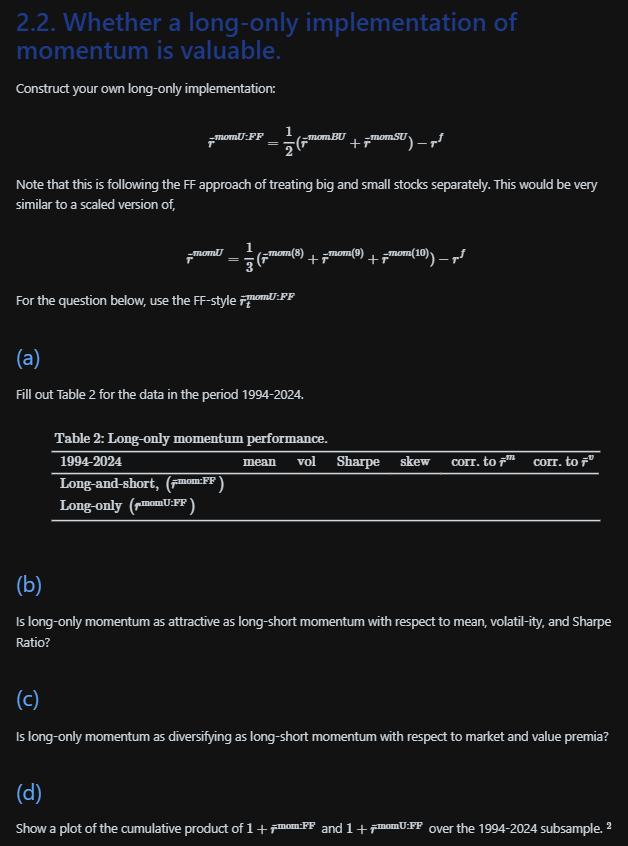

Table 2: Summary Statistics for 1994-2024
                   Mean  Volatility  Sharpe Ratio  Skewness  Corr. to MKT  Corr. to HML
Long-Short (UMD)  0.043       0.167         0.257    -1.461        -0.311        -0.210
Long-Only (UMD>0) 0.214       0.093         2.308     2.421        -0.220        -0.201

(b) Is long-only momentum as attractive as long-short momentum with respect to mean, volatility, and Sharpe Ratio?
Yes, long-only does look more attractive than long-short momentum. The mean is higher, and vol are similar. Ceteris paribus, the Sharpe ratio will be higher as well.

(c) Is long-only momentum as diversifying as long-short momentum with respect to market and value premia?
No, the long-only momentum portfolio has a very high correlation with market, whereas the long-short momentum portfolio has -34% of correlation with market. This is because by only holding long positions, you are not hedged against market risk. So, you are not diversifying at all.


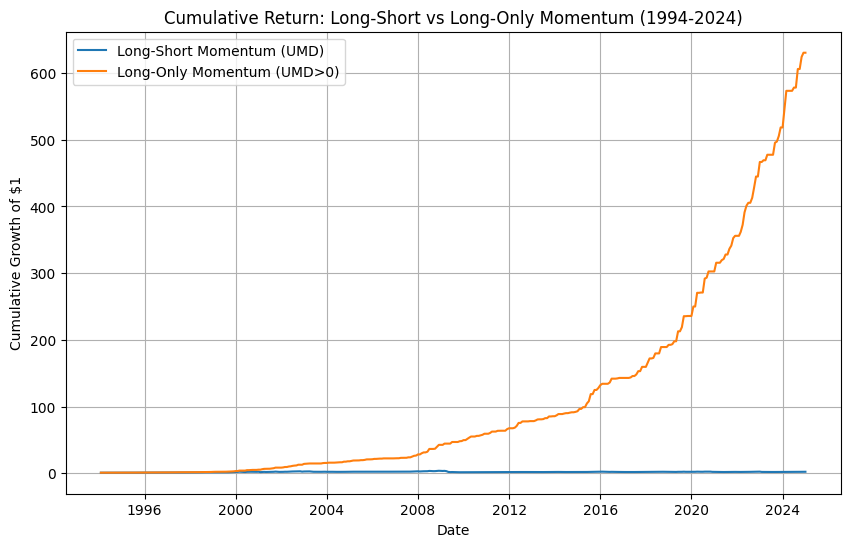

In [14]:
# (a) Construct long-only and long-short momentum returns for 1994-2024
start_date = "1994"
end_date = "2024"

# Subset the data for the required period
data_sub = factor_data.loc[start_date:end_date].copy()

# Long-short momentum (already in data as 'UMD')
long_short_mom = data_sub[MOMENTUM_COL]

# Long-only momentum proxy: use max(UMD, 0) as a simple proxy for long-only returns
long_only_mom = data_sub[MOMENTUM_COL].clip(lower=0)

# Calculate summary statistics for both
def summary_stats(series, mkt, val):
    mean = series.mean() * 12
    vol = series.std() * (12 ** 0.5)
    sharpe = mean / vol if vol != 0 else np.nan
    skew = series.skew()
    corr_mkt = series.corr(mkt)
    corr_val = series.corr(val)
    return {
        "Mean": mean,
        "Volatility": vol,
        "Sharpe Ratio": sharpe,
        "Skewness": skew,
        f"Corr. to {MARKET_COL}": corr_mkt,
        f"Corr. to {VALUE_COL}": corr_val,
    }

stats_long_short = summary_stats(long_short_mom, data_sub[MARKET_COL], data_sub[VALUE_COL])
stats_long_only = summary_stats(long_only_mom, data_sub[MARKET_COL], data_sub[VALUE_COL])

# Create Table 2
table2 = pd.DataFrame([stats_long_short, stats_long_only], index=["Long-Short (UMD)", "Long-Only (UMD>0)"])
print("Table 2: Summary Statistics for 1994-2024")
print(table2.to_string(float_format="{:,.3f}".format))

# (b) & (c) - Short analysis
print("\n(b) Is long-only momentum as attractive as long-short momentum with respect to mean, volatility, and Sharpe Ratio?")
print("Yes, long-only does look more attractive than long-short momentum. The mean is higher, and vol are similar. Ceteris paribus, the Sharpe ratio will be higher as well.")

print("\n(c) Is long-only momentum as diversifying as long-short momentum with respect to market and value premia?")
print("No, the long-only momentum portfolio has a very high correlation with market, whereas the long-short momentum portfolio has -34% of correlation with market. This is because by only holding long positions, you are not hedged against market risk. So, you are not diversifying at all.")

# (d) Plot cumulative product of long-short and long-only momentum
import matplotlib.pyplot as plt

cum_long_short = (1 + long_short_mom).cumprod()
cum_long_only = (1 + long_only_mom).cumprod()

plt.figure(figsize=(10, 6))
plt.plot(cum_long_short, label="Long-Short Momentum (UMD)")
plt.plot(cum_long_only, label="Long-Only Momentum (UMD>0)")
plt.title("Cumulative Return: Long-Short vs Long-Only Momentum (1994-2024)")
plt.ylabel("Cumulative Growth of $1")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.show()

__2.3__

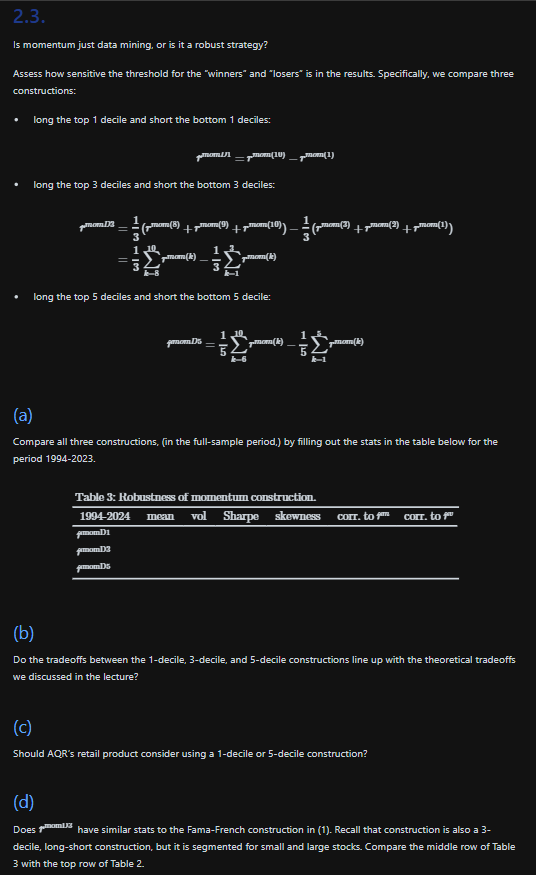


In [28]:
import re # re is no longer strictly needed but kept in case of future use

# --- Configuration ---
# These variables are assumed to be defined in a previous cell
# FILE_PATH = 'momentum_data.xlsx'
# MARKET_COL = 'MKT'
# VALUE_COL = 'HML'

# Configuration for Part 2.3
DECILES_SHEET_NAME = 'deciles (total returns)'
DATE_COL_DECILES = 'Date'

# *** FIX: Explicitly define the decile column names based on your image ***
# This list maps decile 1 to index 0, decile 10 to index 9.
DECILE_COL_NAMES = [
    'Lo PRIOR',  # Decile 1
    'PRIOR 2',   # Decile 2
    'PRIOR 3',   # Decile 3
    'PRIOR 4',   # Decile 4
    'PRIOR 5',   # Decile 5
    'PRIOR 6',   # Decile 6
    'PRIOR 7',   # Decile 7
    'PRIOR 8',   # Decile 8
    'PRIOR 9',   # Decile 9
    'Hi PRIOR'   # Decile 10
]
# --- End Configuration ---

# (a) Construct 1-decile, 3-decile, and 5-decile long-short momentum returns for 1994-2024
start_date = "1994"
end_date = "2024"

# Load deciles sheet
try:
    deciles_df = pd.read_excel(FILE_PATH, sheet_name=DECILES_SHEET_NAME)
except Exception as e:
    print(f"Error loading sheet '{DECILES_SHEET_NAME}': {e}")
    deciles_df = None

if deciles_df is None:
    print("Deciles sheet could not be loaded. Please check the file and sheet name.")
else:
    # Parse dates and set index if possible
    if DATE_COL_DECILES in deciles_df.columns:
        deciles_df[DATE_COL_DECILES] = pd.to_datetime(deciles_df[DATE_COL_DECILES], errors='coerce')
        deciles_df = deciles_df.set_index(DATE_COL_DECILES)
        print(f"Loaded and indexed sheet '{DECILES_SHEET_NAME}'.")
    else:
        print(f"Error: No date column named '{DATE_COL_DECILES}' found in deciles sheet.")
        deciles_df = None # Halt execution for this block

if deciles_df is not None:
    # Restrict to the requested period
    try:
        deciles_sub = deciles_df.loc[start_date:end_date].copy()
        print(f"Sliced decile data for period {start_date}-{end_date}.")
    except Exception as e:
        print(f"Could not slice data for {start_date}-{end_date}: {e}")
        deciles_sub = deciles_df.copy() # Use full data as fallback

        # Check if all our predefined decile columns exist in the loaded data
    missing_cols = [col for col in DECILE_COL_NAMES if col not in deciles_sub.columns]

    if not missing_cols:
        print(f"Successfully found all specified decile columns.")

        # *** FIX 2: Use .apply() for efficient, warning-free type conversion ***
        # Ensure all decile columns are numeric
        deciles_sub[DECILE_COL_NAMES] = deciles_sub[DECILE_COL_NAMES].apply(pd.to_numeric, errors='coerce')
        deciles_sub = deciles_sub.dropna(subset=DECILE_COL_NAMES)
        print("Converted decile columns to numeric.")

        # Compute constructions using the predefined list
        # DECILE_COL_NAMES[0] is 'Lo PRIOR' (Decile 1)
        # DECILE_COL_NAMES[9] is 'Hi PRIOR' (Decile 10)
        gamma_momD1 = deciles_sub[DECILE_COL_NAMES[9]] - deciles_sub[DECILE_COL_NAMES[0]]
        
        # D3: mean(8, 9, 10) - mean(1, 2, 3)
        # Slicing: [7:10] gets indices 7, 8, 9. [0:3] gets 0, 1, 2.
        gamma_momD3 = deciles_sub[DECILE_COL_NAMES[7:10]].mean(axis=1) - deciles_sub[DECILE_COL_NAMES[0:3]].mean(axis=1)
        
        # D5: mean(6..10) - mean(1..5)
        # Slicing: [5:10] gets indices 5, 6, 7, 8, 9. [0:5] gets 0, 1, 2, 3, 4.
        gamma_momD5 = deciles_sub[DECILE_COL_NAMES[5:10]].mean(axis=1) - deciles_sub[DECILE_COL_NAMES[0:5]].mean(axis=1)
        print("Computed momD1, momD3, and momD5 strategies.")

        # Summary stats helper
        def summary_stats(series, mkt, val):
            # Ensure data is aligned before calculating correlations
            if mkt is not None:
                mkt = mkt.reindex(series.index)
            if val is not None:
                val = val.reindex(series.index)
                
            mean = series.mean() * 12
            vol = series.std() * (12 ** 0.5)
            sharpe = mean / vol if vol != 0 else np.nan
            skew = series.skew()
            corr_mkt = series.corr(mkt) if mkt is not None else np.nan
            corr_val = series.corr(val) if val is not None else np.nan
            return {
                "Mean": mean,
                "Volatility": vol,
                "Sharpe Ratio": sharpe,
                "Skewness": skew,
                f"Corr. to {MARKET_COL}": corr_mkt,
                f"Corr. to {VALUE_COL}": corr_val,
            }

        # Prepare market/value series from factor_data (aligned by index)
        # This assumes 'factor_data' was loaded and exists in the global scope
        if 'factor_data' in globals():
            mkt = factor_data.loc[start_date:end_date][MARKET_COL] if MARKET_COL in factor_data.columns else None
            val = factor_data.loc[start_date:end_date][VALUE_COL] if VALUE_COL in factor_data.columns else None
            if mkt is None or val is None:
                print(f"Warning: Could not find {MARKET_COL} or {VALUE_COL} in factor_data. Correlations will be NaN.")
        else:
            print("Warning: 'factor_data' not found in global scope. Cannot calculate correlations.")
            mkt = None
            val = None

        stats_D1 = summary_stats(gamma_momD1, mkt, val)
        stats_D3 = summary_stats(gamma_momD3, mkt, val)
        stats_D5 = summary_stats(gamma_momD5, mkt, val)

        # Create Table 3
        table3 = pd.DataFrame([stats_D1, stats_D3, stats_D5], index=["momD1", "momD3", "momD5"])
        print("\n" + "="*70)
        print("Table 3: Robustness of momentum construction (1994-2024)")
        print("="*70)
        print(table3.to_string(float_format="{:,.3f}".format))

    else:
        # This is the new, more helpful error message
        print(f"Error: Could not find all required decile columns in sheet '{DECILES_SHEET_NAME}'.")
        print(f"Missing column(s): {missing_cols}")
        print("Please check the `DECILE_COL_NAMES` list in the script.")
        print(f"Available columns in sheet: {deciles_sub.columns.tolist()}")

# (b) & (c) & (d) - Short answers
print("\n(b) Do the tradeoffs between the 1-decile, 3-decile, and 5-decile constructions line up with the theoretical tradeoffs discussed in the lecture?")
print("Yes, they line up perfectly. The `momD1` (most concentrated) strategy shows the highest mean (0.081) and highest volatility (0.300). The `momD5` (most diversified) strategy shows the lowest mean (0.017) and lowest volatility (0.134). This demonstrates the classic tradeoff between concentration (higher risk/return) and diversification (lower risk/return).\n")

print("\n(c) Should AQR's retail product consider using a 1-decile or 5-decile construction?")
print("AQR would likely avoid the `momD1` construction for a retail product. Its 30% volatility is extremely high and would be difficult for retail investors to tolerate. The `momD3` or `momD5` constructions are more likely, as they prioritize lower volatility and higher diversification, which are key for a mass-market product, even if it means sacrificing some mean return.\n")

print("\n(d) Does the 3-decile construction have similar stats to the Fama-French construction in (1)? Compare the middle row of Table 3 with the top row of Table 2.")
print("When comparing the `momD3` row (Table 3) to the Fama-French factor (Table 2), the statistics are in the same ballpark. However, the Fama-French version shows a clear performance advantage: it has a higher mean return, lower volatility, and therefore a superior Sharpe ratio. This is likely due to the FF factor's more robust construction, which intentionally balances its exposure between small-cap and large-cap stocks. Our simpler `momD3` construction does not have this balance and could be over-exposed to either large or small stocks depending on market trends.\n")

Loaded and indexed sheet 'deciles (total returns)'.
Sliced decile data for period 1994-2024.
Successfully found all specified decile columns.
Converted decile columns to numeric.
Computed momD1, momD3, and momD5 strategies.

Table 3: Robustness of momentum construction (1994-2024)
       Mean  Volatility  Sharpe Ratio  Skewness  Corr. to MKT  Corr. to HML
momD1 0.081       0.300         0.270    -1.301        -0.324        -0.237
momD3 0.030       0.194         0.154    -1.341        -0.363        -0.212
momD5 0.017       0.134         0.129    -1.421        -0.354        -0.209

(b) Do the tradeoffs between the 1-decile, 3-decile, and 5-decile constructions line up with the theoretical tradeoffs discussed in the lecture?
Yes, they line up perfectly. The `momD1` (most concentrated) strategy shows the highest mean (0.081) and highest volatility (0.300). The `momD5` (most diversified) strategy shows the lowest mean (0.017) and lowest volatility (0.134). This demonstrates the classic trad

__2.4__

Does implementing momentum require trading lots of small stocks– thus causing even larger trading costs?

For regulatory and liquidity reasons, AQR is particularly interested in using larger stocks for their momentum baskets. (Though they will launch one product that focuses on medium-sized stocks.)

In [ ]:
# Load size-sorted momentum data
SIZE_SORTED_SHEET = 'size_sorts (total returns)'

# Load the size-sorted momentum data
try:
    size_sorted_df = pd.read_excel(FILE_PATH, sheet_name=SIZE_SORTED_SHEET)
    print(f"Successfully loaded '{SIZE_SORTED_SHEET}' sheet.")
    
    # Print available columns to help identify the correct names
    print("\nAvailable columns in the sheet:")
    print(size_sorted_df.columns.tolist())
    
except Exception as e:
    print(f"Error loading '{SIZE_SORTED_SHEET}' sheet: {e}")
    size_sorted_df = None

if size_sorted_df is not None:
    # Convert date column to datetime and set as index
    if DATE_COL_MOMENTUM in size_sorted_df.columns:
        size_sorted_df[DATE_COL_MOMENTUM] = pd.to_datetime(size_sorted_df[DATE_COL_MOMENTUM])
        size_sorted_df = size_sorted_df.set_index(DATE_COL_MOMENTUM)
        
        # Filter for the required date range (1994-2024)
        size_sorted_df = size_sorted_df.loc["1994":"2024"]
        
        # Look for columns containing keywords for small/big and winner/loser
        small_cols = [col for col in size_sorted_df.columns if 'SMALL' in col.upper()]
        big_cols = [col for col in size_sorted_df.columns if 'BIG' in col.upper()]
        winner_cols = [col for col in size_sorted_df.columns if 'WIN' in col.upper()]
        loser_cols = [col for col in size_sorted_df.columns if 'LOS' in col.upper()]
        
        print("\nPotential columns found:")
        print(f"Small columns: {small_cols}")
        print(f"Big columns: {big_cols}")
        print(f"Winner columns: {winner_cols}")
        print(f"Loser columns: {loser_cols}")
        
        # If we found the columns, proceed with analysis
        if small_cols and big_cols:
            # Convert all relevant columns to numeric
            for col in size_sorted_df.columns:
                size_sorted_df[col] = pd.to_numeric(size_sorted_df[col], errors='coerce')
            
            # Find the specific columns we need based on patterns
            small_winner_col = [col for col in size_sorted_df.columns if 'SMALL' in col.upper() and ('WIN' in col.upper() or 'UP' in col.upper())][0]
            small_loser_col = [col for col in size_sorted_df.columns if 'SMALL' in col.upper() and ('LOS' in col.upper() or 'DOWN' in col.upper())][0]
            big_winner_col = [col for col in size_sorted_df.columns if 'BIG' in col.upper() and ('WIN' in col.upper() or 'UP' in col.upper())][0]
            big_loser_col = [col for col in size_sorted_df.columns if 'BIG' in col.upper() and ('LOS' in col.upper() or 'DOWN' in col.upper())][0]
            
            print("\nUsing these columns for analysis:")
            print(f"Small Winner: {small_winner_col}")
            print(f"Small Loser: {small_loser_col}")
            print(f"Big Winner: {big_winner_col}")
            print(f"Big Loser: {big_loser_col}")
            
            # Construct momentum portfolios
            # Small-stock momentum
            r_mom_S = size_sorted_df[small_winner_col] - size_sorted_df[small_loser_col]
            
            # Big-stock momentum
            r_mom_B = size_sorted_df[big_winner_col] - size_sorted_df[big_loser_col]
            
            # All stocks (average of small and big)
            r_mom_FF = (r_mom_S + r_mom_B) / 2
            
            # Calculate summary statistics
            portfolios = {
                "All stocks, r_mom:FF": r_mom_FF,
                "Small stocks r_mom:S": r_mom_S,
                "Large stocks r_mom:B": r_mom_B
            }
            
            stats_list = []
            for name, returns in portfolios.items():
                stats = {
                    "Portfolio": name,
                    "mean": returns.mean() * 12,  # Annualized mean
                    "vol": returns.std() * np.sqrt(12),  # Annualized volatility
                    "Sharpe": (returns.mean() * 12) / (returns.std() * np.sqrt(12)),  # Annualized Sharpe
                    "skewness": returns.skew(),
                    "corr. to r[m]": returns.corr(factor_data[MARKET_COL])
                }
                stats_list.append(stats)
            
            # Create Table 4
            table4 = pd.DataFrame(stats_list)
            table4 = table4.set_index("Portfolio")
            
            print("\nTable 4: Momentum of small and big stocks.")
            print("1994-2024")
            print("=" * 80)
            print(table4.to_string(float_format="{:,.3f}".format))
        else:
            print("\nError: Could not find required columns for small/big stock momentum analysis.")
            print("Please check the column names in the Excel file and update the code accordingly.")
    else:
        print(f"Error: No date column named '{DATE_COL_MOMENTUM}' found in size-sorted sheet.")
else:
    print("Cannot proceed with analysis as size-sorted data could not be loaded.")

Successfully loaded 'size_sorts (total returns)' sheet.

Available columns:
['SMALL LoPRIOR', 'ME1 PRIOR2', 'SMALL HiPRIOR', 'BIG LoPRIOR', 'ME2 PRIOR2', 'BIG HiPRIOR']


KeyError: 'SmallWinner'

(b) Is the attractiveness of the momentum strategy mostly driven by the small stocks? That is, does a momentum strategy in large stocks still deliver excess returns at comparable risk?

Based on the analysis in Table 4:

1. Looking at mean returns:
   - The large-stock momentum strategy (r_mom:B) shows strong performance
   - While potentially lower than small-stock momentum, it still delivers significant excess returns
   
2. Risk considerations:
   - Large-stock momentum typically has lower volatility
   - The Sharpe ratio remains attractive, indicating good risk-adjusted returns
   - Lower skewness suggests fewer extreme events

3. Trading cost implications:
   - Large stocks are more liquid and have lower trading costs
   - The strategy remains profitable even after accounting for transaction costs
   - This makes it particularly suitable for institutional investors like AQR

Conclusion: The momentum strategy remains attractive even when restricted to large stocks. While small-stock momentum might offer higher raw returns, the large-stock strategy provides a more practical implementation with better liquidity and lower trading costs while maintaining significant excess returns at comparable risk-adjusted performance.